In [ ]:
!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install -U scikit-learn
!pip install ipympl
!pip install seaborn
!pip install pyarrow
#!pip install pyodbc

In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import json
pd.options.display.float_format = '{:,.0f}'.format

In [ ]:
# dfreco = pd.read_csv("recommendations.csv")
# dfreco.to_parquet("recommendations.parquet")

In [ ]:
dfreco = pd.read_parquet("recommendations.parquet")
dfgame = pd.read_csv("games.csv")
dfuser = pd.read_csv("users.csv")
dfmeta = pd.read_json('games_metadata.json', lines=False)

In [2]:
dfuser = pd.read_csv("users.csv")
dfuser.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 327.4 MB


In [45]:
(1.5*dfuser.reviews.quantile(0.95)-dfuser.reviews.quantile(0.10))+dfuser.reviews.quantile(0.95)

21.5

In [46]:
len(dfuser[dfuser.reviews > 21.5])

180284

In [52]:
scaler = StandardScaler()
hu = dfuser[dfuser.reviews > 21.5][['reviews']].values
scaler.fit_transform(hu)


array([[-0.13667225],
       [-0.40109845],
       [-0.30666052],
       ...,
       [ 0.05220361],
       [ 0.69438154],
       [-0.28777293]])

In [57]:
dfuser['log_reviews'] = np.log10(dfuser.reviews+1)

In [72]:

scaler = StandardScaler()
hu = dfuser[['log_reviews']].values
dfuser['scaled_reviews'] = scaler.fit_transform(hu)

upper_range = (1.5*dfuser.scaled_reviews.quantile(0.90)-dfuser.scaled_reviews.quantile(0.10))+dfuser.scaled_reviews.quantile(0.90)

high_reviews = dfuser[dfuser.scaled_reviews > upper_range]

high_reviews.scaled_reviews

114        5 
183        5 
199        5 
254        6 
468        5 
           ..
14297587   4 
14297789   6 
14300628   5 
14304388   4 
14304876   5 
Name: scaled_reviews, Length: 64085, dtype: float64

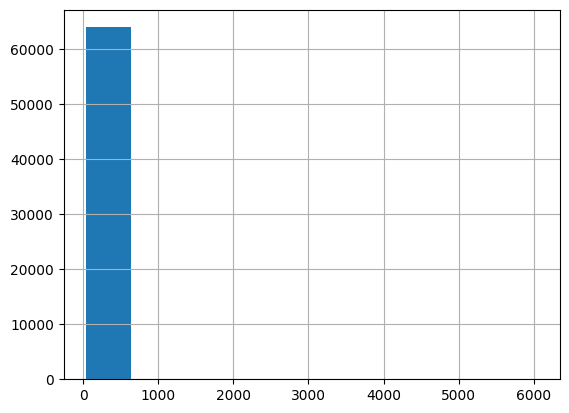

For n_clusters = 2 The average silhouette_score is : 0.8503156752106075
For n_clusters = 3 The average silhouette_score is : 0.7843300924673495
For n_clusters = 4 The average silhouette_score is : 0.7232439245918646
For n_clusters = 5 The average silhouette_score is : 0.7171183551962033
For n_clusters = 6 The average silhouette_score is : 0.8200779015548653
For n_clusters = 7 The average silhouette_score is : 0.7775449433951662
For n_clusters = 8 The average silhouette_score is : 0.8382294167871669
For n_clusters = 9 The average silhouette_score is : 0.835115010019737
For n_clusters = 10 The average silhouette_score is : 0.8893686402653269
For n_clusters = 11 The average silhouette_score is : 0.8893686402653269
For n_clusters = 12 The average silhouette_score is : 0.9503747132593624
For n_clusters = 13 The average silhouette_score is : 0.9522019588262741
For n_clusters = 114 The average silhouette_score is : 0.984069978698335
For n_clusters = 15 The average silhouette_score is : 0.9479

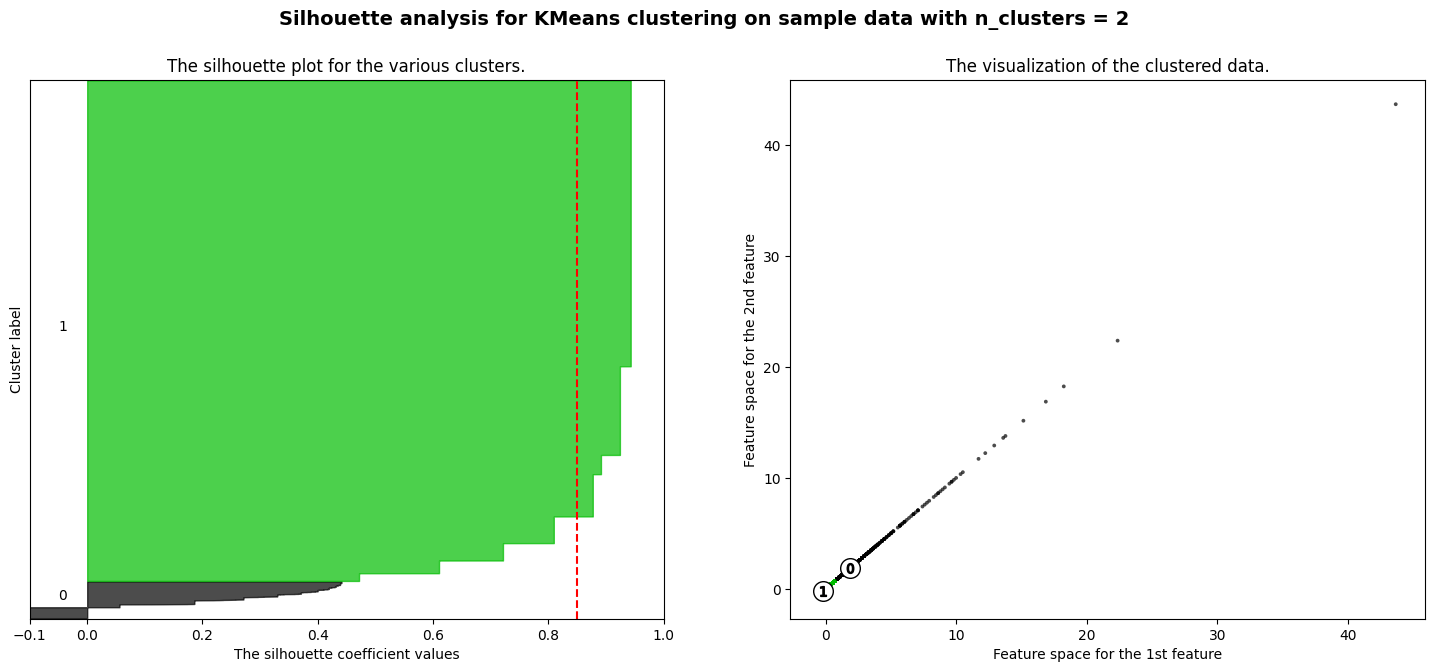

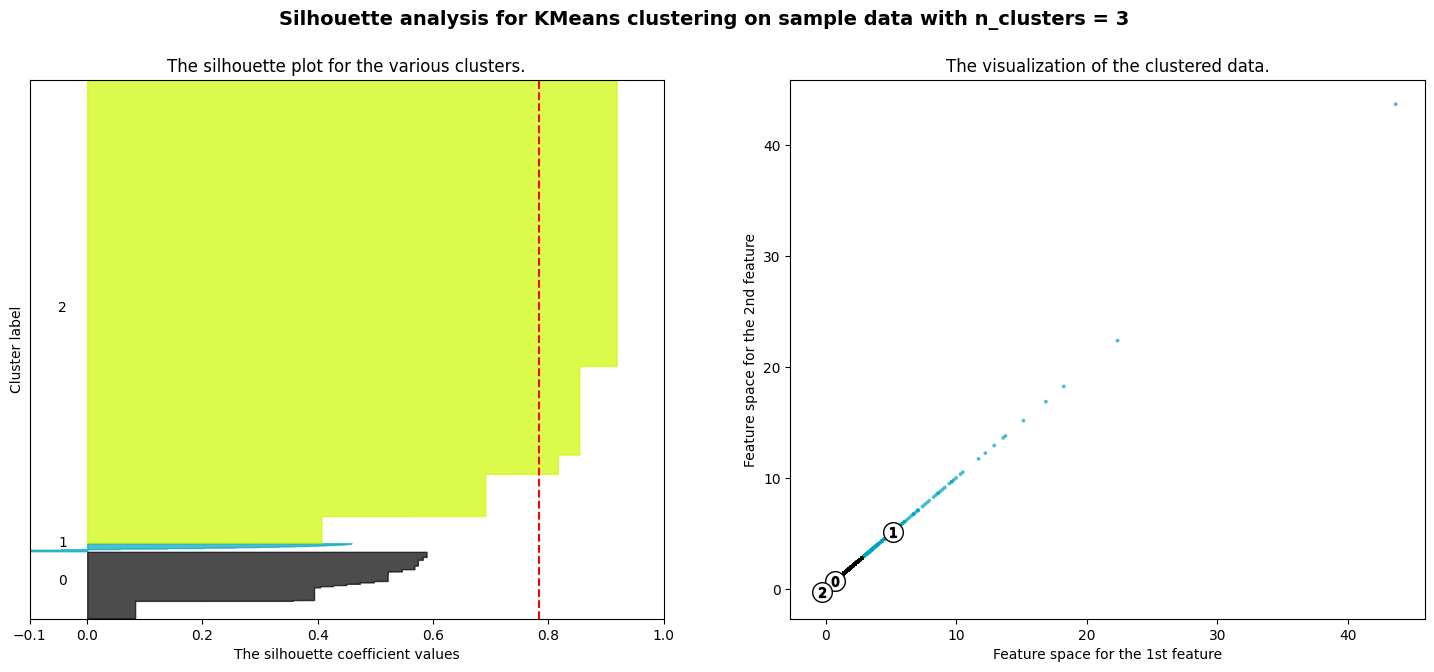

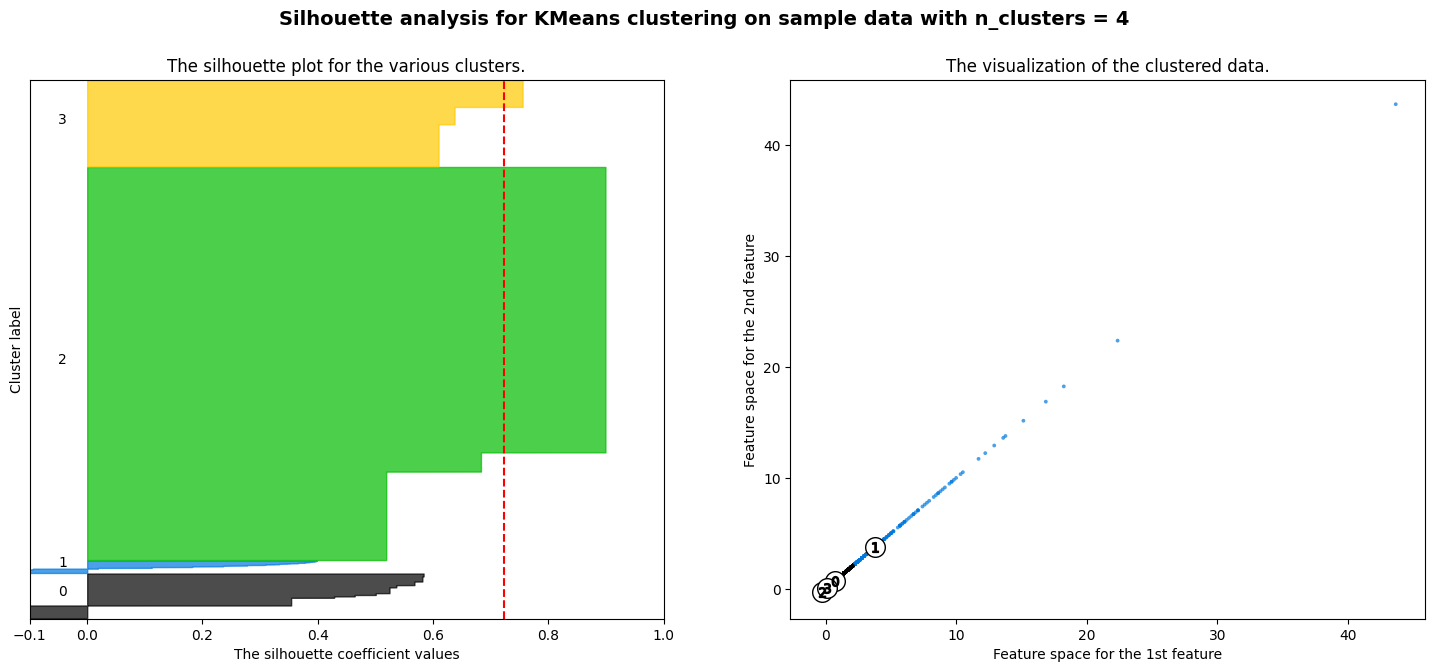

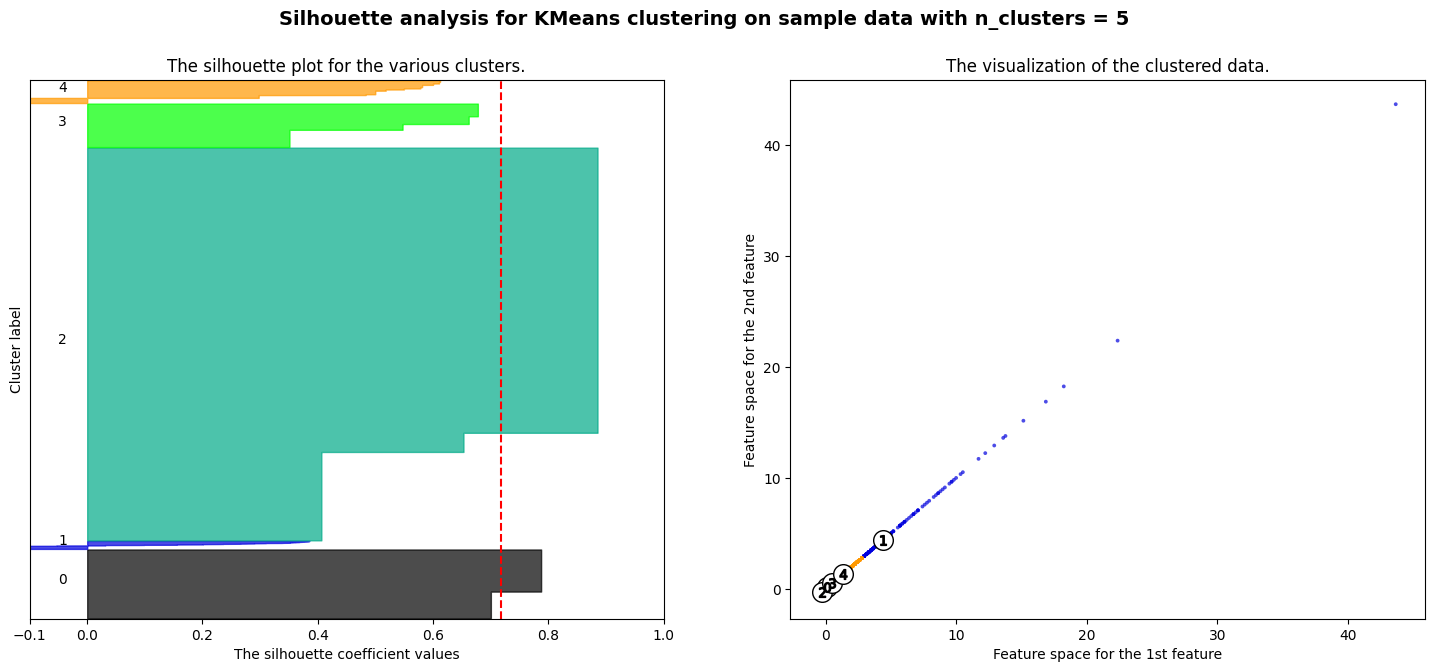

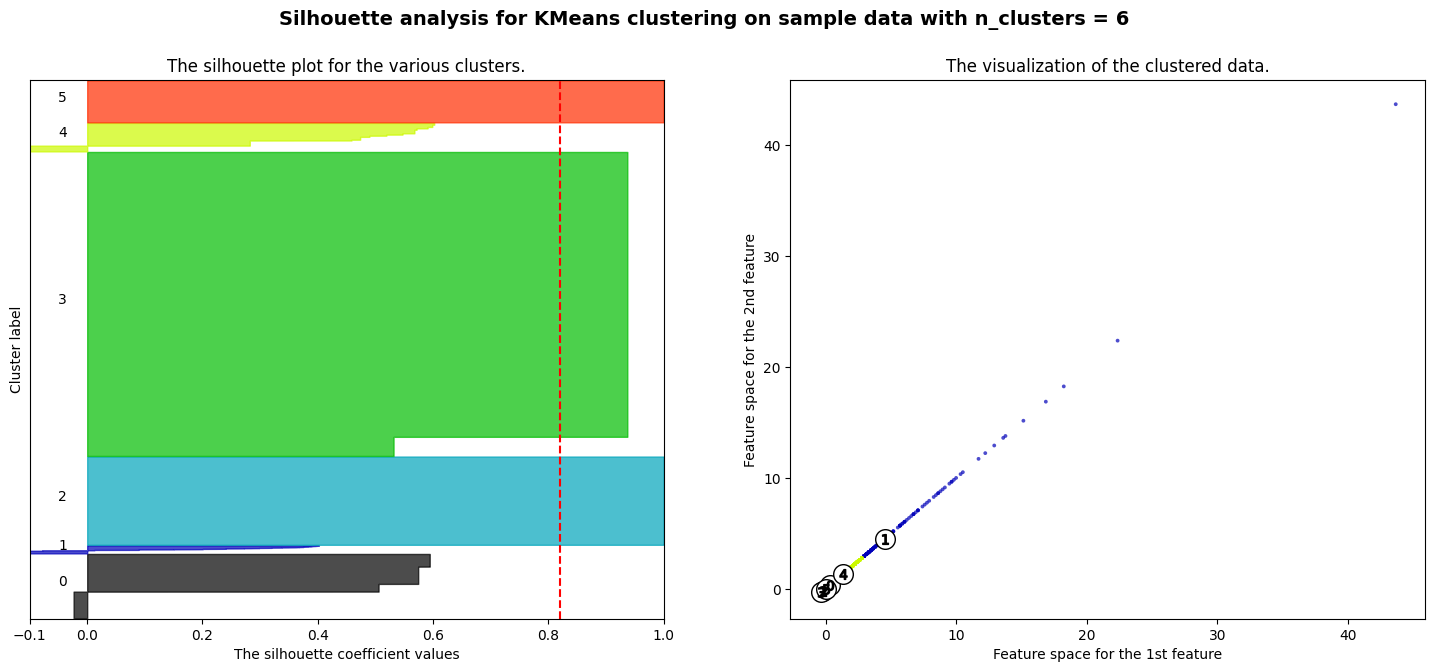

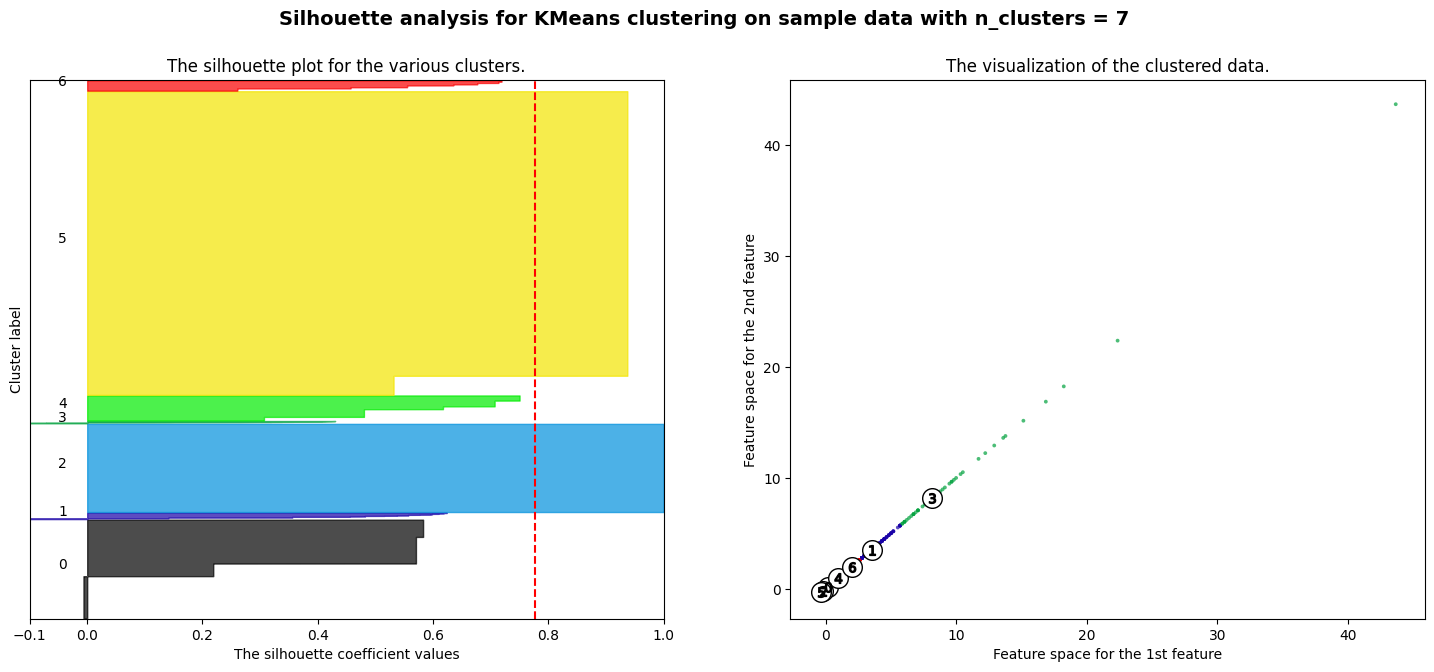

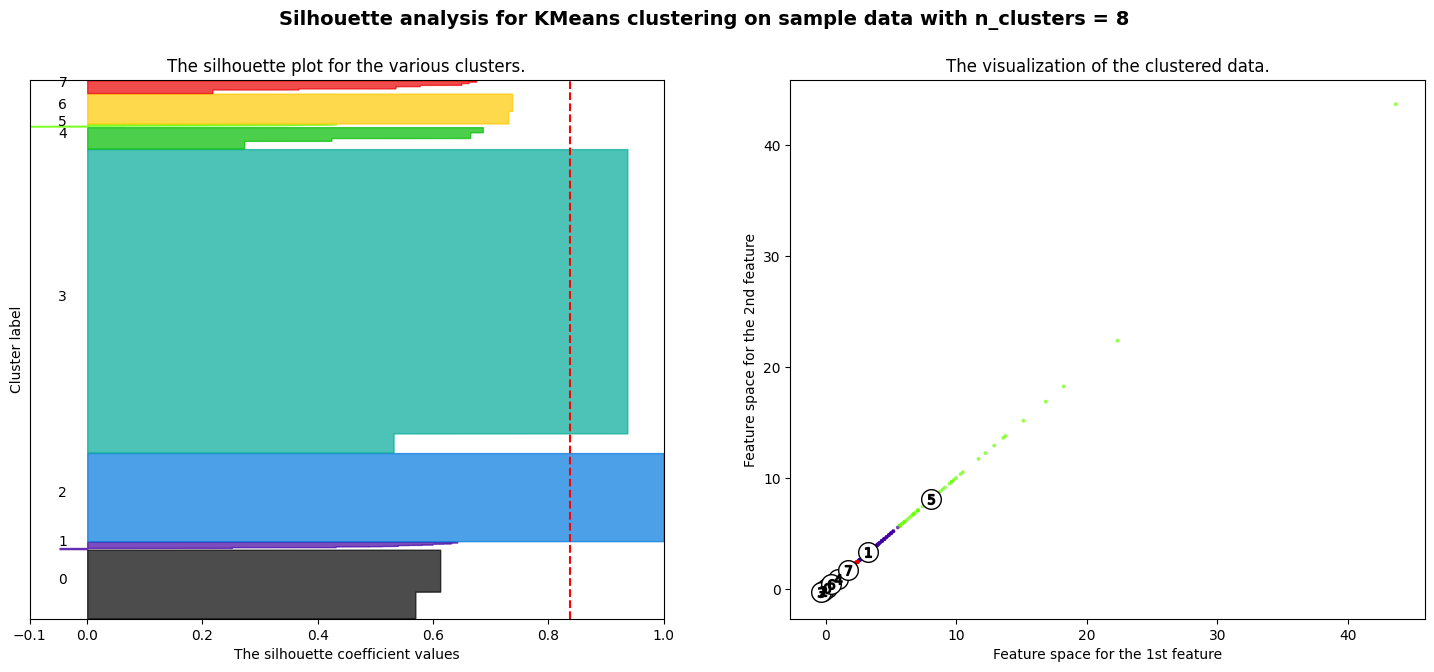

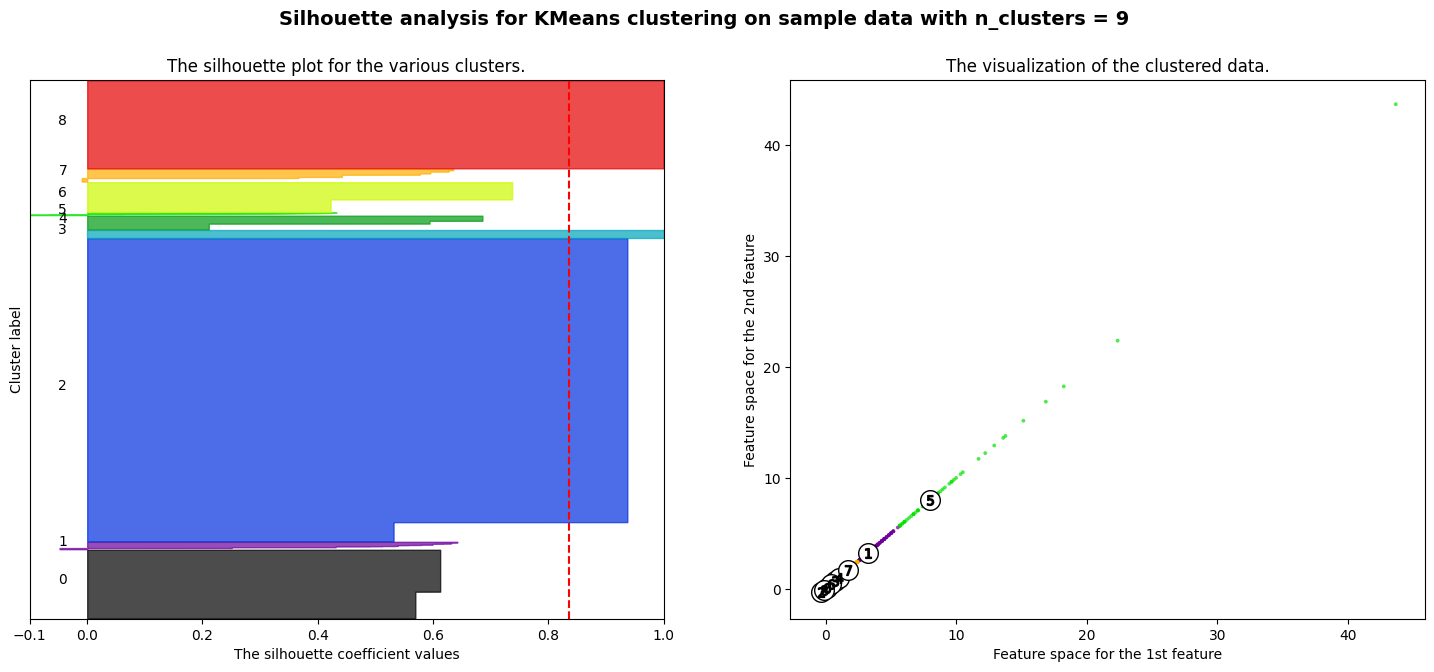

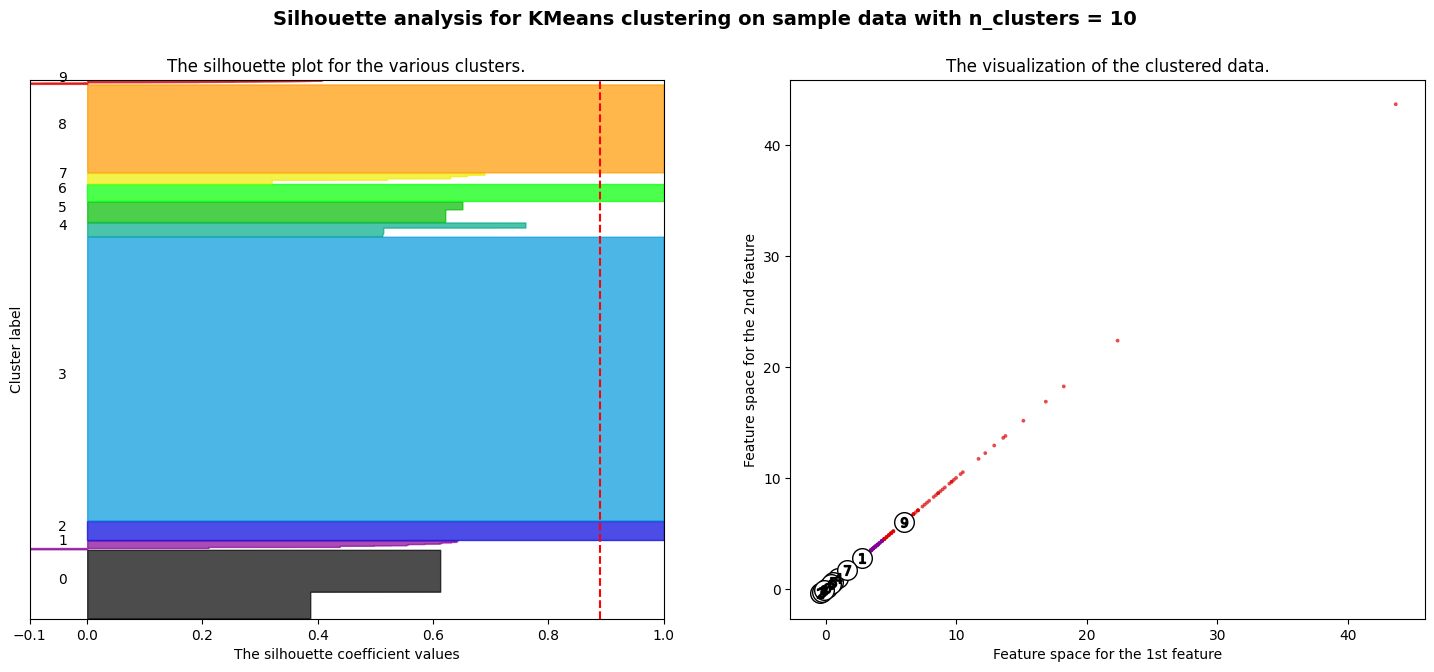

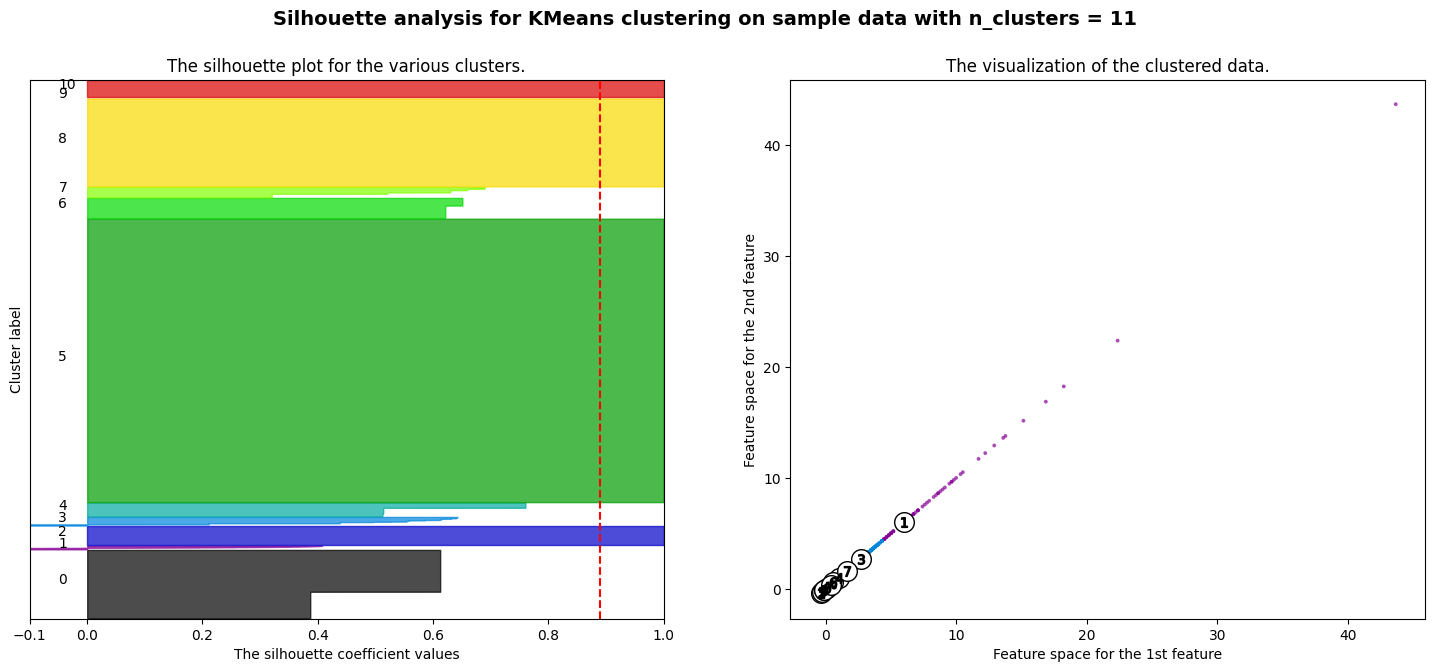

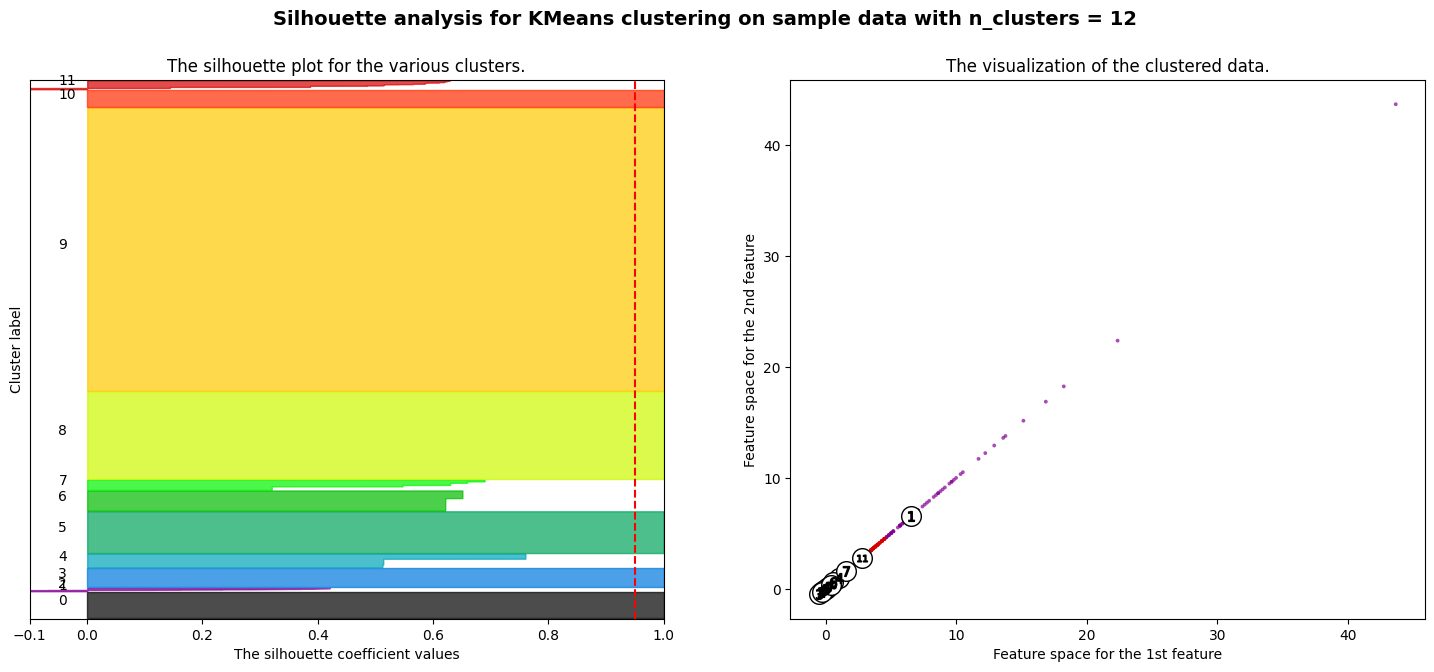

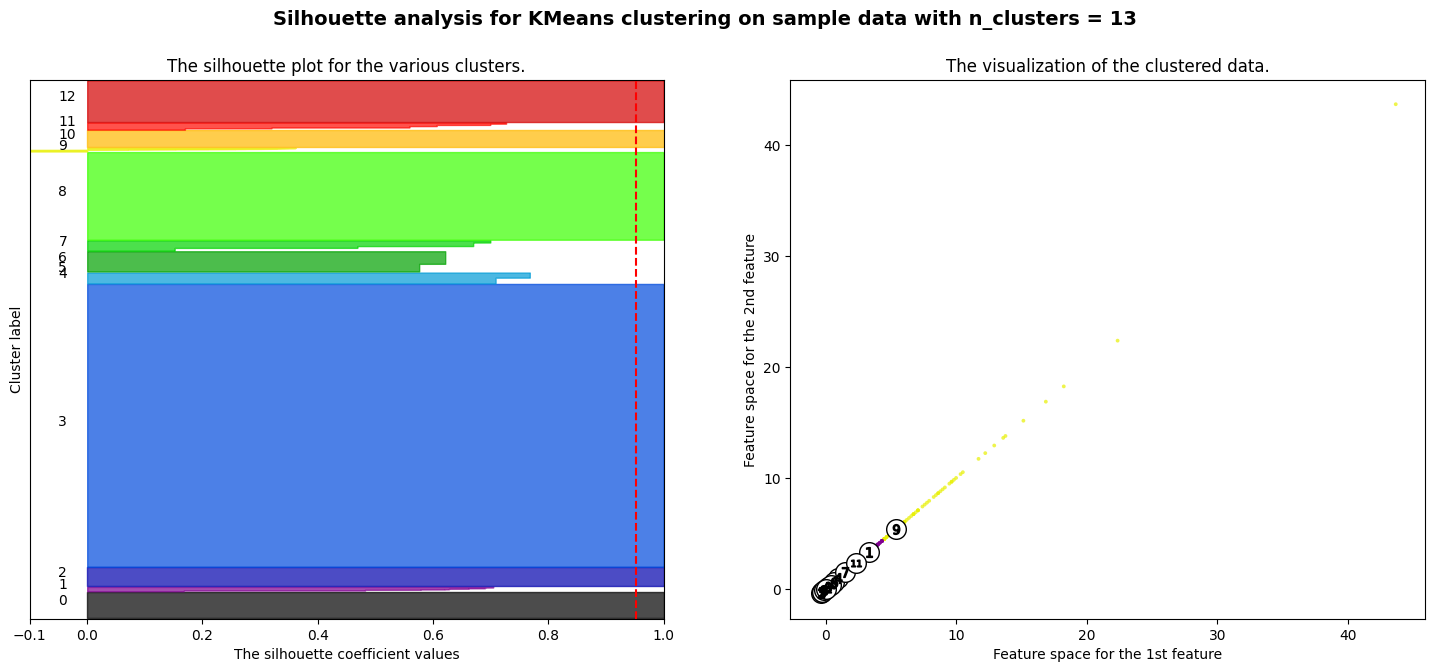

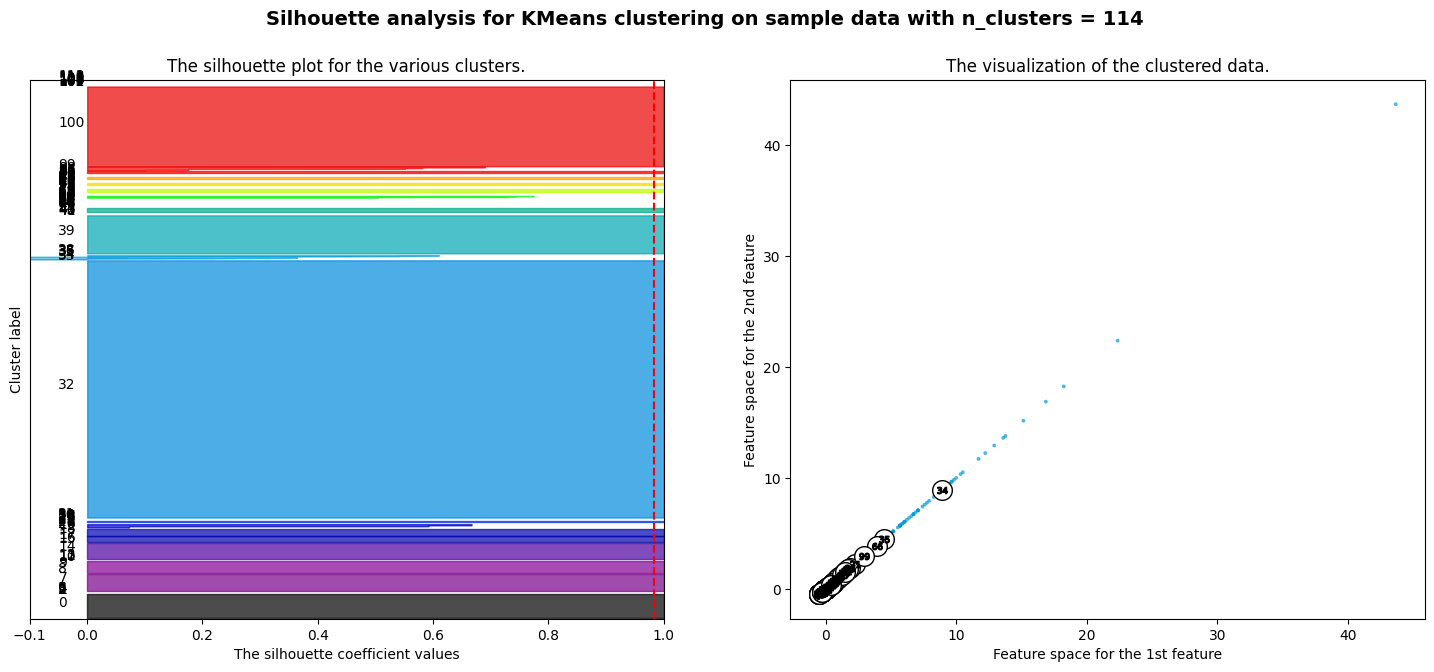

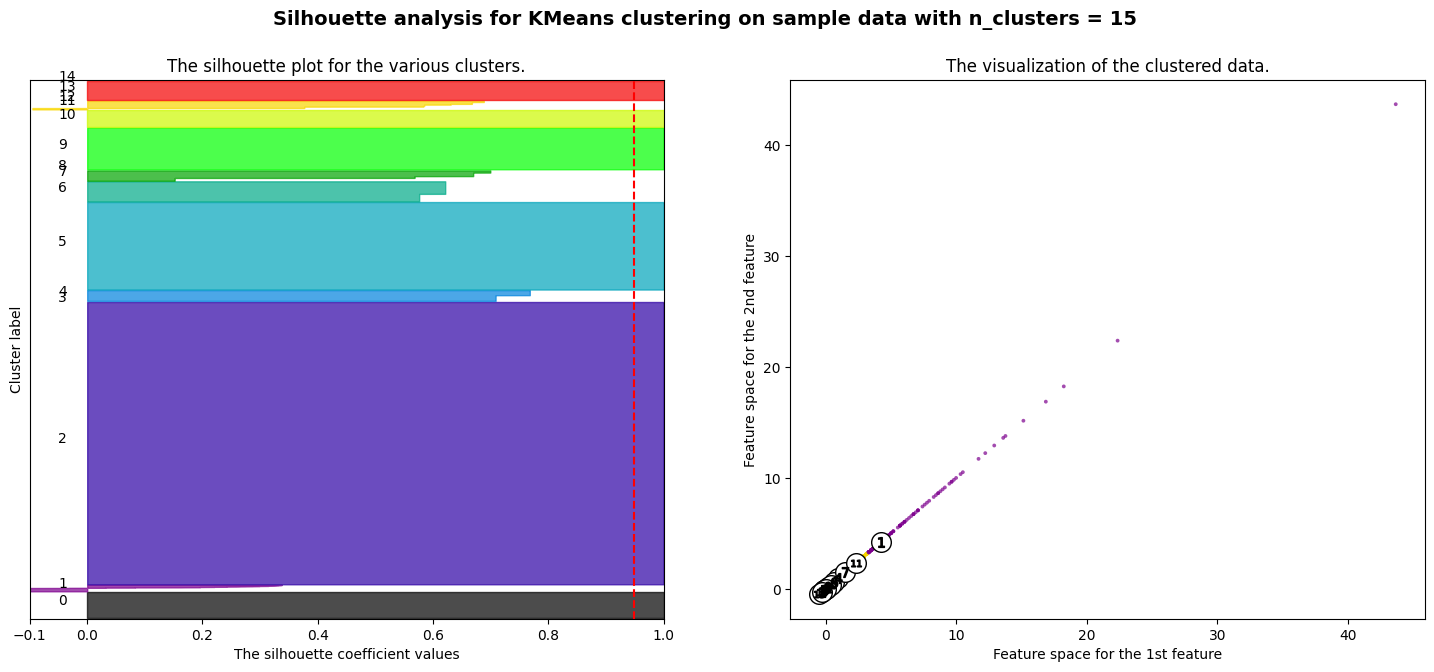

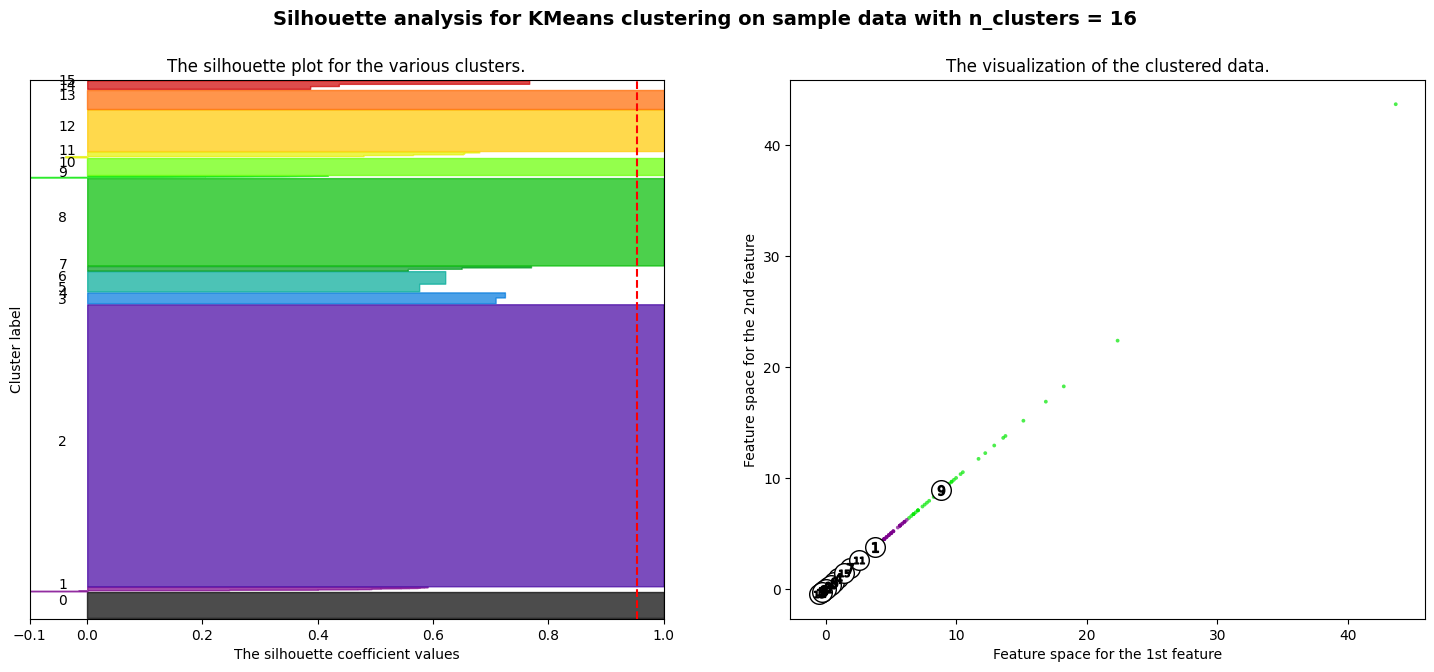

In [32]:
#Let's cluster users on number of reviews performed and see if we see a definite pattern of users
scaler = StandardScaler()
X = scaler.fit_transform(dfuser[['reviews']].sample(n=10000, random_state=1).values)
n_clusters = [2,3,4,5,6,7,8,9,10,11,12,13,114,15,16]

for n in n_clusters:
    cmod = MiniBatchKMeans(n_clusters=n, random_state=42)
    labels = cmod.fit_predict(X)
    
    silhouette_avg = silhouette_score(X, labels)
    print(
        "For n_clusters =",
        n,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    sample_silhouette_values = silhouette_samples(X, labels)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n + 1) * 10])
    
    y_lower = 10
    for i in range(n):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(labels.astype(float) / n)
    ax2.scatter(
        X[:, 0], X[:, 0], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = cmod.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 0],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[0], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n,
        fontsize=14,
        fontweight="bold",
    )

plt.show()



In [ ]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
%matplotlib inline

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()